# 013.Boston House Price Regression

### 13 개의 종속변수와 1 개의 독립변수 (주택가격 중앙값) 으로 구성

#### 종속변수 (13 개)
CRIM 자치시(town) 별 1인당 범죄율  
ZN 25,000 평방피트를 초과하는 거주지역의 비율  
INDUS 비소매상업지역이 점유하고 있는 토지의 비율  
CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)  
NOX 10ppm 당 농축 일산화질소  
RM 주택 1가구당 평균 방의 개수  
AGE 1940년 이전에 건축된 소유주택의 비율  
DIS 5개의 보스턴 직업센터까지의 접근성 지수  
RAD 방사형 도로까지의 접근성 지수  
TAX 10,000 달러 당 재산세율  
PTRATIO 자치시(town)별 학생/교사 비율  
B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함  
LSTAT 모집단의 하위계층의 비율(%)   

#### 독립변수 (1 개)
MEDV 본인 소유의 주택가격(중앙값) (단위: $1,000)  

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
boston = load_boston()
df_boston = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
X = boston.data
y = boston.target

In [7]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


In [9]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [10]:
X_train_ts = torch.tensor(X_train, dtype=torch.float)
X_test_ts = torch.tensor(X_test, dtype=torch.float)
y_train_ts = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
y_test_ts = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

X_train_ts.shape, X_test_ts.shape, y_train_ts.shape, y_test_ts.shape

(torch.Size([404, 13]),
 torch.Size([102, 13]),
 torch.Size([404, 1]),
 torch.Size([102, 1]))

### Linear Model build
- one layer linear regression model 

In [11]:
class LinearReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReg, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [12]:
model = LinearReg(X_train.shape[1], 1).to(device)
model

LinearReg(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### dataset loader 생성

In [14]:
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

## The training process 
- Batch data Load 
- model 을 이용하여 batch data 예측  
- loss value 계산 
- optimizer 에 저장된 grad value clear
- loss value backpropagate 
- optimizer update  

In [15]:
Loss = []
num_epochs = 300
for epoch in range(num_epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    Loss.append(loss.item())

epoch 1 loss: 543.9327
epoch 2 loss: 544.4004
epoch 3 loss: 535.9500
epoch 4 loss: 497.0813
epoch 5 loss: 268.4644
epoch 6 loss: 305.2076
epoch 7 loss: 164.4207
epoch 8 loss: 191.2301
epoch 9 loss: 134.0422
epoch 10 loss: 169.3299
epoch 11 loss: 149.9606
epoch 12 loss: 99.3970
epoch 13 loss: 105.2309
epoch 14 loss: 64.4289
epoch 15 loss: 165.4215
epoch 16 loss: 107.5209
epoch 17 loss: 58.3597
epoch 18 loss: 58.1551
epoch 19 loss: 46.4133
epoch 20 loss: 25.1538
epoch 21 loss: 75.0489
epoch 22 loss: 84.0359
epoch 23 loss: 86.4699
epoch 24 loss: 18.3666
epoch 25 loss: 28.3900
epoch 26 loss: 33.6756
epoch 27 loss: 22.0071
epoch 28 loss: 25.1875
epoch 29 loss: 63.6660
epoch 30 loss: 24.8758
epoch 31 loss: 21.6440
epoch 32 loss: 34.7018
epoch 33 loss: 40.2583
epoch 34 loss: 58.9840
epoch 35 loss: 81.8373
epoch 36 loss: 44.7920
epoch 37 loss: 17.6323
epoch 38 loss: 26.8597
epoch 39 loss: 61.3331
epoch 40 loss: 40.7673
epoch 41 loss: 18.2809
epoch 42 loss: 51.1583
epoch 43 loss: 85.4506
epoch 

In [16]:
print(criterion(model(X_test_ts.to(device)), y_test_ts.to(device)).item())

10.723152160644531


Text(0, 0.5, 'MSE loss')

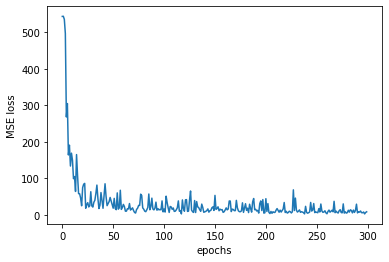

In [17]:
plt.plot(Loss)
plt.xlabel("epochs")
plt.ylabel("MSE loss")

In [18]:
y_pred = model(X_test_ts.to(device))

In [19]:
y_pred = y_pred.cpu().detach().numpy()

In [22]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_pred))

0.8599367797851067


Text(0.5, 1.0, 'Boston House Price Prediction ($1,000)')

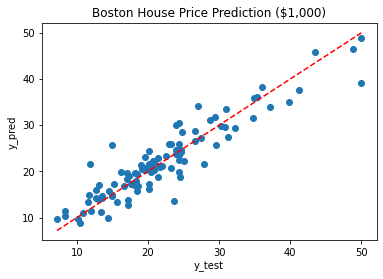

In [23]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', c='r')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Boston House Price Prediction ($1,000)')